# Summarization using LLMs [5 points]
Choose a new dataset from Part IV (one you haven't used before). Repeat the steps from Part IV, and deploy the resulting model.

## Steps:

1. Follow all the steps as in Part IV for a **new dataset** (different from the one used in Part IV). Provide a brief analysis of the results. You are welcome to reuse your code from Part IV.

   **Dataset Selection (New Dataset from Part IV List):**
   Selected Multi-News Dataset.

In [2]:
import os
import numpy as np
!pip install datasets evaluate rouge_score nltk bert_score
!pip install transformers
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
import nltk
#from datasets import load_metric
from evaluate import load
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
!pip install sacrebleu
import sacrebleu
import bert_score
import torch
import pandas as pd
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Using device:', device)
dataset = load_dataset("multi_news")

def show_dataset_stats(dataset):
    print(f"Dataset splits: {dataset.keys()}")
    for split in dataset:
        print(f"\n{split} set:")
        print(f"  Samples: {len(dataset[split])}")
        sample = dataset[split][0]
        print(f"  Sample keys: {sample.keys()}")
        print(f"  Example text length: {len(sample['document'])}")
        print(f"  Example summary length: {len(sample['summary'])}")

show_dataset_stats(dataset)

if 'validation' not in dataset:
    dataset = DatasetDict({
        'train': dataset['train'].train_test_split(test_size=0.1, seed=42)['train'],
        'validation': dataset['train'].train_test_split(test_size=0.1, seed=42)['test']
    })

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset splits: dict_keys(['train', 'validation', 'test'])

train set:
  Samples: 44972
  Sample keys: dict_keys(['document', 'summary'])
  Example text length: 1708
  Example summary length: 443

validation set:
  Samples: 5622
  Sample keys: dict_keys(['document', 'summary'])
  Example text length: 9469
  Example summary length: 1314

test set:
  Samples: 5622
  Sample keys: dict_keys(['document', 'summary'])
  Example text length: 10367
  Example summary length: 881


In [ ]:
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
max_input_length = 1024
max_target_length = 256

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["document"],
        max_length=max_input_length,
        padding="max_length",
        truncation=True
    )
    labels = tokenizer(
        examples["summary"],
        max_length=max_target_length,
        padding="max_length",
        truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets.save_to_disk("tokenized_multinews")
tokenized_datasets = DatasetDict.load_from_disk("tokenized_multinews")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]
    return preds, labels

from transformers import PreTrainedTokenizerFast

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    if isinstance(preds[0], str):
        print("Predictions seem to be in text form, tokenizing them.")
        preds = tokenizer(preds, padding=True, truncation=True, return_tensors="pt")["input_ids"]

    if isinstance(labels[0], str):
        print("Labels seem to be in text form, tokenizing them.")
        labels = tokenizer(labels, padding=True, truncation=True, return_tensors="pt")["input_ids"]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    decoded_preds = [pred if pred else "<empty>" for pred in decoded_preds]
    decoded_labels = [label if label else "<empty>" for label in decoded_labels]
    rouge_scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # bleu_score = bleu.compute(predictions=[word_tokenize(pred) for pred in decoded_preds],
    #                           references=[word_tokenize(ref) for ref in decoded_labels])
    #bleu_score = bleu.compute(predictions=decoded_preds, references=[decoded_labels])
    bleu_score = bleu.compute(predictions=decoded_preds, references=[[label] for label in decoded_labels])
    bert_score = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    result = {
        "rouge1": rouge_scores["rouge1"] * 100,
        "rouge2": rouge_scores["rouge2"] * 100,
        "rougeL": rouge_scores["rougeL"] * 100,
        "bleu": bleu_score["bleu"] * 100,
        "bertscore": np.mean(bert_score["f1"]) * 100
    }
    return result

class CustomTrainer(Seq2SeqTrainer):
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        eval_dataloader = self.get_eval_dataloader(eval_dataset)
        model = self.model
        model.eval()
        loss_output = super().evaluate(eval_dataset=eval_dataset, ignore_keys=ignore_keys, metric_key_prefix=metric_key_prefix)
        eval_loss = loss_output[f"{metric_key_prefix}_loss"]
        generation_args = {
            "num_beams": 5,
            "max_length": max_target_length,
            "length_penalty": 1.0,
            "early_stopping": True,
            "no_repeat_ngram_size": 3
        }

        all_preds = []
        all_labels = []
        for batch in eval_dataloader:
            batch = {k: v.to(self.args.device) for k, v in batch.items()}
            labels = batch["labels"]
            inputs = batch["input_ids"]
            with torch.no_grad():
                outputs = model.generate(inputs, **generation_args)

            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            all_preds.extend(decoded_preds)
            all_labels.extend(labels.tolist())

        metrics = compute_metrics((all_preds, all_labels))
        metrics = {f"{metric_key_prefix}_{k}": v for k, v in metrics.items()}
        metrics[f"{metric_key_prefix}_loss"] = eval_loss
        self.log(metrics)
        return metrics


    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        if labels is not None and return_outputs:
            labels = labels.view(-1)
        return super().compute_loss(model, inputs, return_outputs)

Map:   0%|          | 0/44972 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/44972 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5622 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    num_train_epochs=4,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_rouge1",
    greater_is_better=True,
    fp16=True,
    push_to_hub=False,
    predict_with_generate=True
)

callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    train_dataset=tokenized_datasets["train"].select(range(1000)),
    eval_dataset=tokenized_datasets["validation"].select(range(100)),
    compute_metrics=compute_metrics,
    callbacks=callbacks,
)

trainer.train()
best_model_path = "best_summary_model.pth"
torch.save(trainer.model.state_dict(), best_model_path)
print(f"Best model weights saved to {best_model_path}")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-e1e341f63022>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ruthvikvkumar (ruthvikvkumar-university-at-buffalo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Bleu,Bertscore
1,3.143400,2.671545,9.693577,3.339434,7.455288,0.000118,83.662887
2,2.630200,2.442390,9.776041,3.246800,7.552861,0.000105,83.787356
3,2.508700,2.403487,10.190559,3.446827,7.973262,0.000121,83.916050


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predictions seem to be in text form, tokenizing them.


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Predictions seem to be in text form, tokenizing them.
Predictions seem to be in text form, tokenizing them.


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Best model weights saved to best_summary_model.pth


In [ ]:
# Final evaluation on test set
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["validation"].select(range(100)))
print("Final Test Results: ")
for k, v in test_results.items():
    print(f"{k}: {v:.2f}")

df_log = pd.DataFrame(trainer.state.log_history)
df_log = df_log[df_log["epoch"].notna()]

Predictions seem to be in text form, tokenizing them.
Final Test Results: 
eval_rouge1: 40.88
eval_rouge2: 13.39
eval_rougeL: 21.03
eval_bleu: 11.00
eval_bertscore: 85.60
eval_loss: 2.44
epoch: 3.00


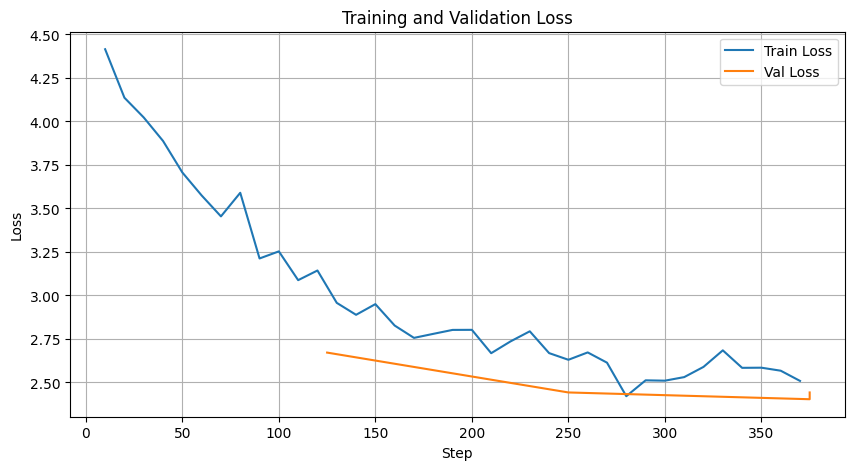

In [ ]:
eval_loss_df = df_log[df_log["eval_loss"].notna() & df_log["step"].notna()]

plt.figure(figsize=(10, 5))
if "loss" in df_log.columns:
    train_loss_df = df_log[df_log["loss"].notna() & df_log["step"].notna()]
    plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Train Loss")
if not eval_loss_df.empty:
    plt.plot(eval_loss_df["step"], eval_loss_df["eval_loss"], label="Val Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

   **Brief Analysis of Results:**

1. **Training vs. Validation Loss**:
   - The training loss decreased steadily from 3.14 (epoch 1) to 2.51 (epoch 3), which indicates the model is learning and improving during training.
   - The validation loss also decreased, though more gradually, from 2.67 (epoch 1) to 2.44 (final test), showing the model is not overfitting and generalizes well to unseen data, especially since early stopping was applied.

2. **Rouge Scores**:
   - **Rouge1 (Recall-oriented metric)**: The Rouge1 score improved from 9.69 (epoch 1) to 10.19 (epoch 3), suggesting the model's ability to match unigrams between the generated and reference texts is improving.
   - **Rouge2 (Bigram recall)**: It showed small fluctuations (from 3.34 to 3.45), which suggests there is room for improvement in capturing more complex sequences in the output.
   - **RougeL (Longest common subsequence)**: Similarly, it improved from 7.46 to 7.97, which suggests better coherence in the generated text.

3. **BLEU Score**:
   - The BLEU score (11.00) is quite low, indicating that the model's generated text is not very close to reference translations. BLEU typically rewards exact matches of n-grams, so this might point to issues with word choice, sentence structure, or vocabulary richness.

4. **BERTScore**:
   - A BERTScore of 85.60 is strong, suggesting that the model's output closely matches the reference in terms of contextual meaning (using embeddings), even though BLEU and Rouge scores are lower.

5. **Evaluation Loss**:
   - The evaluation loss of 2.44 aligns closely with the final validation loss, indicating stable performance on the test set.

**Conclusion**:
The model seems to be learning well and generalizing on unseen data, with strong BERTScore performance indicating good semantic alignment. However, the BLEU score suggests there is potential to improve fluency and exact matches of n-grams. The Rouge scores indicate that the model is relatively good at capturing both local (unigrams) and more global (longest subsequences) structure in the generated text.

2. Deploy your trained model. This could be a simple app that takes a text as input and returns a summary.

This model is deployed at - https://huggingface.co/spaces/ruthvikvkumar/summarizer

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)
model.load_state_dict(torch.load("best_summary_model.pth"))
model.to(device)
model.eval()

# Input text for summarization
input_text = """
Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the
natural intelligence displayed by humans and animals. Leading AI textbooks define the field
as the study of "intelligent agents": any device that perceives its environment and takes
actions that maximize its chance of successfully achieving its goals. Colloquially, the term
"artificial intelligence" is often used to describe machines (or computers) that mimic
"cognitive" functions that humans associate with the human mind, such as "learning" and
"problem-solving".
"""

# Tokenize the input
inputs = tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True, padding='max_length')
inputs = {key: value.to(device) for key, value in inputs.items()}

# Generate summary using the loaded model
summary_ids = model.generate(inputs["input_ids"], max_length=150, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:")
summary_lines = summary.split('. ')
for line in summary_lines:
    print(line.strip() + '.')

Using device: cuda


<ipython-input-21-12ef07ae6332>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_summary_model.pth"))


Generated Summary:
Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the Ânatural intelligence displayed by humans and animals.
Leading AI textbooks define the field Â"artificial intelligence"—as the study of "intelligent agents": any device that perceives its environment and takes Â'actions that maximize its chance of successfully achieving its goals.
Colloquially, the term ÂArtificial Intelligence" is used to describe machines (or computers) that mimic Â "natural intelligence" or "cognitive" functions that humans associate with the human mind, such as "learning" and ÂÂÂ"problem-solving"..


3. Record a short video (~5 mins) demonstrating how it works. Explain the key aspects of your implementation and deployment process in the video.
   a. Upload the video to UBbox and create a shared link
   b. Add the link at the end of your ipynb file.

   **Shared UBbox Video Link:**
   https://buffalo.box.com/s/sy8udummozutn70rkzik7tnx8fs3o583

# References:
1. https://huggingface.co/datasets/FiscalNote/billsum
2. https://huggingface.co/datasets/alexfabbri/multi_news
3. https://pypi.org/project/datasets/
4. https://huggingface.co/facebook/bart-base
5. https://huggingface.co/spaces/evaluate-metric/rouge
6. https://huggingface.co/spaces/evaluate-metric/bleu
7. https://huggingface.co/spaces/evaluate-metric/bertscore
8. https://www.kaggle.com/code/ashwinnaidu/textsummarization/notebook
9. https://www.analyticsvidhya.com/blog/2023/07/build-a-text-summariser-using-llms-with-hugging-face/
10. https://huggingface.co/docs/transformers/en/model_doc/bart